In [1]:
import pandas as pd
import numpy as np
import maddpkg
import matplotlib.pyplot as plt
import pickle

In [2]:
model = "LR"
sensitive_feature = "poverty"

In [3]:
y_pp = pickle.load(open("./data_EDM23/y_pp_" + model + "_" + sensitive_feature, "rb"))
X_test = pd.read_csv("./data_courseBBB/X_test_stClick_7030.csv")

## Generation of h based on m

In [4]:
m = np.arange(1, 500, 1)
e = 1/m
e = e[::-1]

In [5]:
madd = [maddpkg.MADD(X_test, y_pp, sensitive_feature, ei) for ei in e]

## MADD min

In [6]:
madd_min_ind = np.argmin(madd)
print("MADD minimum:", madd[madd_min_ind])
print("e associated:", e[madd_min_ind])

MADD minimum: 0.0
e associated: 1.0


## Orders of h

In [7]:
n0 = len(X_test[X_test[sensitive_feature] == 0])
n1 = len(X_test[X_test[sensitive_feature] == 1])
order = ( (n0**(1/2) + n1**(1/2)) / (n0*n1)**(1/2) )**(2/3)
print(n0)
print(n1)
print(order)

662
928
0.17257716851605825


In [8]:
h_inf = 0.01*order
h_mid = 0.1*order
print(h_inf)
print(h_mid)

0.0017257716851605826
0.017257716851605827


In [9]:
if h_inf > e[0]:
    ind_e_inf = np.where(e <= h_inf)[0][-1]
else:
    ind_e_inf = 0
ind_e_mid = np.where(e <= h_mid)[0][-1]
ind_e_sup_or_ind_order = np.where(e <= order)[0][-1]

## MADD(h) on [0, 1]

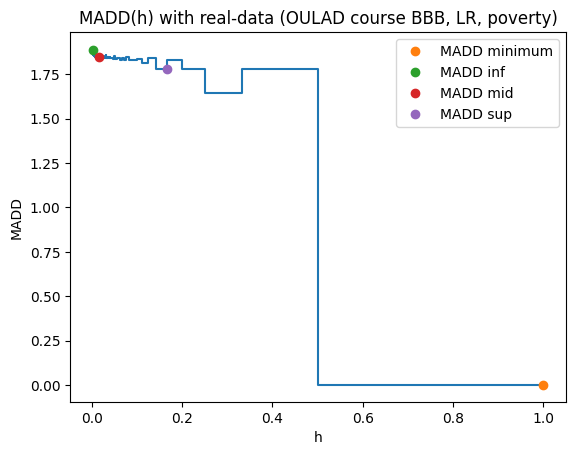

In [10]:
plt.step(e, madd)
plt.plot(e[madd_min_ind], madd[madd_min_ind], "o", label="MADD minimum")
plt.plot(e[ind_e_inf], madd[ind_e_inf], "o", label="MADD inf")
plt.plot(e[ind_e_mid], madd[ind_e_mid], "o", label="MADD mid")
plt.plot(e[ind_e_sup_or_ind_order], madd[ind_e_sup_or_ind_order], "o", label="MADD sup")
plt.xlabel("h")
plt.ylabel("MADD")
plt.title("MADD(h) with real-data (OULAD course BBB, " + model + ", " + sensitive_feature + ")")
plt.legend()

## MADD(e) focus on [0, 1]*optimal order

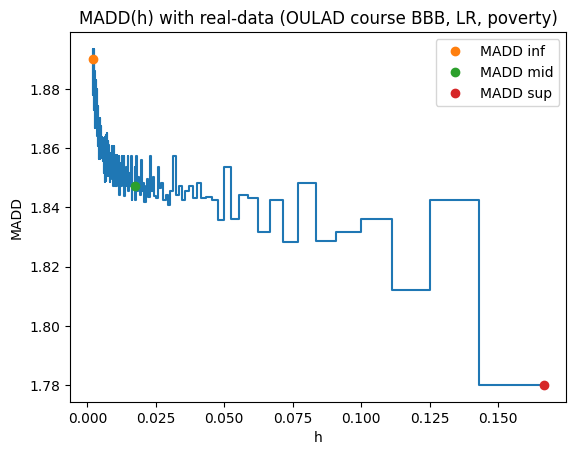

In [11]:
plt.step(e[:ind_e_sup_or_ind_order+1], madd[:ind_e_sup_or_ind_order+1], where="pre")
plt.plot(e[:ind_e_sup_or_ind_order+1][ind_e_inf], madd[:ind_e_sup_or_ind_order+1][ind_e_inf], "o", label="MADD inf")
plt.plot(e[:ind_e_sup_or_ind_order+1][ind_e_mid], madd[:ind_e_sup_or_ind_order+1][ind_e_mid], "o", label="MADD mid")
plt.plot(e[:ind_e_sup_or_ind_order+1][ind_e_sup_or_ind_order], madd[:ind_e_sup_or_ind_order+1][ind_e_sup_or_ind_order], "o", label="MADD sup")
plt.xlabel("h")
plt.ylabel("MADD")
plt.title("MADD(h) with real-data (OULAD course BBB, " + model + ", " + sensitive_feature + ")")
plt.legend()

In [12]:
ind_cv = np.where(e< 0.025)[0][-1]

In [13]:
madd[ind_cv]

1.8503099281175122

## Mean on [0, 1]*optimal order

In [14]:
np.mean(madd[ind_e_mid:ind_e_sup_or_ind_order])

1.8442512290943769

## Advanced interval selection

In [15]:
def calculate_std(y, start, end):
    """计算区间 [start, end] 内的标准差"""
    return np.std(y[start:end+1])

def find_stable_interval_advanced(m_list, madd_list, n0=None, n1=None, min_interval_length=None, min_nb_points=50):
    # calculate the minimum of interval length if n0 and n1 are given and if min_interval_length is not given
    if n0 is None or n1 is None:
        if min_interval_length is None:
            min_interval_length = 0.05
    elif type(n0) is int and type(n1) is int:
        if min_interval_length is None:
            order = ( (n0**(1/2) + n1**(1/2)) / (n0*n1)**(1/2) )**(2/3)
            min_interval_length = order * (1 - 0.1) / 2
    else:
        raise ValueError('n0 and n1 must be both None or both int')

    # reverse the lists
    h_list = (1/m_list)[::-1]
    y_list = madd_list[::-1]

    nb_y = len(y_list)

    # initialize the variables
    min_std = float('inf')
    interval = (0, 0)
    max_h = h_list[-1]

    for i in range(0, nb_y):
        x_start = h_list[i]
        # if the x_start is too big, we stop the loop
        if x_start > max_h - min_interval_length:
            break
        x_min_sup = x_start + min_interval_length
        # find the index of the greatest x that is smaller than x_stop
        index_min_sup = np.searchsorted(h_list, x_min_sup, side='right') - 1
        # if the number of points in the interval is too small, we continue the loop
        if index_min_sup - i < min_nb_points:
            continue
        # we calculate the std of the interval [i, j]
        for j in range(index_min_sup, nb_y):
            std = calculate_std(y_list, i, j)
            if std < min_std:
                min_std = std
                interval = (i,j)

    result = {'interval': interval, 'min_std': min_std, 'average': np.average(y_list[interval[0]:interval[1]+1]),
              'min_interval_length': min_interval_length}
    return result


def plot_stable_interval(m_list, madd_list, n0, n1, interval, zoom='None', show_order=True, show_stable=True):
    # reverse the lists
    h_list = (1 / m_list)[::-1]
    y_list = madd_list[::-1]

    # plot the stable interval and the average y of the stable interval on the previous plot
    plt.step(h_list, y_list, where="pre")

    order = ( (n0**(1/2) + n1**(1/2)) / (n0*n1)**(1/2) )**(2/3)
    # plot vertical lines at the optimal bandwidths
    if show_order:
        plt.axvline(x= 0.05 * order, color="r", linestyle="--")
        plt.axvline(x= 0.1 * order, color="r", linestyle="--")
        plt.axvline(x= order , color="r", linestyle="--")
    # plot vertical lines at the stable interval and the horizontal line at the average y of the stable interval
    if show_stable:
        plt.axvline(x=h_list[interval[0]], color="g", linestyle="--")
        plt.axvline(x=h_list[interval[1]], color="g", linestyle="--")
        plt.axhline(y=np.average(y_list[interval[0]:interval[1]+1]), color="g", linestyle="--")

    # zoom the plot
    if zoom == 'None':
        plt.xlim(0, np.max(h_list))
    elif zoom == 'sup order':
        plt.xlim(0, order)
    elif zoom == 'middle order':
        plt.xlim(0, 0.1 * order)
    elif zoom == 'inf order':
        plt.xlim(0, 0.05 * order)
    elif zoom == 'stable':
        plt.xlim(h_list[interval[0]], h_list[interval[1]])
    elif type(zoom) is tuple:
        plt.xlim(zoom[0], zoom[1])
    else:
        raise ValueError('zoom must be None, "sup order", "middle order", "inf order", "stable" or a tuple')

    plt.xlabel("h")
    plt.ylabel("MADD")
    plt.show()

In [16]:
result_stable = find_stable_interval_advanced(m, madd[::-1], n0, n1, min_interval_length=0.025, min_nb_points=50)

In [17]:
result_stable

{'interval': (421, 475),
 'min_std': 0.004576461356942291,
 'average': 1.8482434249779807,
 'min_interval_length': 0.025}

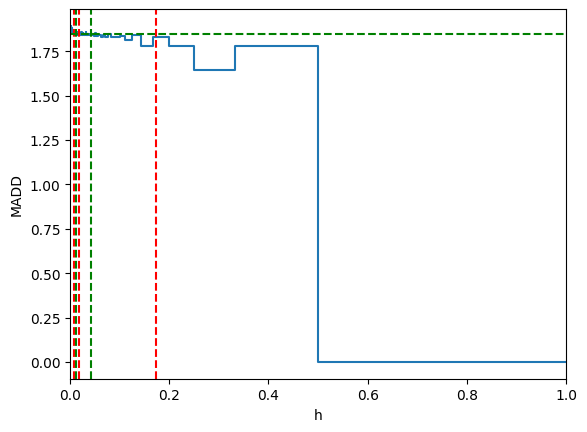

In [18]:
plot_stable_interval(m, madd[::-1], n0, n1, interval=result_stable['interval'])

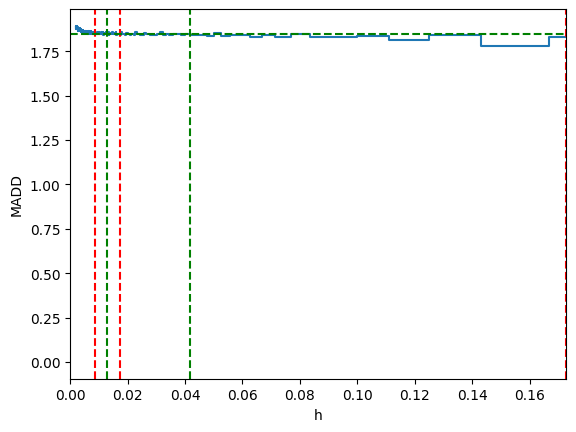

In [19]:
plot_stable_interval(m, madd[::-1], n0, n1, interval=result_stable['interval'], zoom='sup order')

In [144]:
def calculate_std(y, start, end):
    """Calculate the standard deviation in the interval [start, end] of y.
    
    Parameters
    y: List or np.ndarray
    start: int
        Index of the beginning of the subinterval
    end: int
        Index of the beginning of the subinterval
    
    Returns
    float
    
    """
    # add a verification of start and end being int
    
    return np.std(y[start:end+1])

def find_stable_interval_advanced2(h_list, madd_list, n0=None, n1=None, min_interval_length=None, min_nb_points=50):

    # if n0 and n1 are given, min_interval_length is automatically calculated (even if given)
    # otherwise, min_interval_length is set either to the given value or to a default value
    if type(n0) is int and type(n1) is int:
        order = ( (n0**(1/2) + n1**(1/2)) / (n0*n1)**(1/2) )**(2/3)
        min_interval_length = order * (1 - 0.1) / 2
    elif n0 is None or n1 is None:
        if min_interval_length is None:
            min_interval_length = 0.05
    else:
        raise Exception('n0 and n1 arguments must be both None or both int.')

    # initialize the variables
    min_std = float('inf')
    indexes = (0, 0)
    max_h = h_list[-1]

    for i in range(0, len(madd_list)):
        
        x_start = h_list[i]
        
        # if the x_start is too big, we stop the loop
        if x_start > max_h - min_interval_length:
            break
        
        # find the index of the greatest x that is smaller than x_stop
        x_min_sup = x_start + min_interval_length
        index_min_sup = np.searchsorted(h_list, x_min_sup, side='right') - 1
        
        # if the number of points in the interval is too small, we continue the loop
        if index_min_sup - i < min_nb_points:
            continue
        
        # we calculate the std of the interval [i, j]
        for j in range(index_min_sup, len(madd_list)):
            std = calculate_std(madd_list, i, j)
            if std < min_std:
                min_std = std
                indexes = (i, j)

    result = {'min interval length': min_interval_length,
              'indexes': indexes, 
              'h interval': "[{start}, {end}]".format(start=round(h_list[indexes[0]], 3),
                                                      end=round(h_list[indexes[1]+1], 3)), 
              'min madd std': min_std, 
              'madd average': np.average(madd_list[indexes[0] : indexes[1]+1])
             }
    return result


def plot_stable_interval2(h_list, madd_list, show_stable=True, indexes=None, show_order=False, n0=None, n1=None, zoom="None"):
    
    if show_stable is True:
        if indexes is None:
            raise Exception("indexes argument should be given when show_stable=True.")
    
    if show_order is True:
        if n0 is None or n1 is None:
            raise Exception('n0 and n1 arguments must be given when show_order=True.')
    
    if zoom != "None":
        if n0 is None or n1 is None:
            raise Exception('n0 and n1 arguments must be given when zoom is not "None".')
        elif zoom == "stable":
            if indexes is None:
                raise Exception('indexes argument should be given when zoom is "stable".')

    if type(n0) is int and type(n0) is int:
        order = ( (n0**(1/2) + n1**(1/2)) / (n0*n1)**(1/2) )**(2/3)

    plt.step(h_list, madd_list, where="pre", color="black")
    
    if show_order:
        plt.axvline(x= 0.05 * order, color="r", linestyle="--", label="h inferior order ({0})".format(round(0.05 * order, 2)))
        plt.axvline(x= 0.1 * order, color="r", linestyle="--", label="h middle order ({0})".format(round(0.1 * order, 2)))
        plt.axvline(x= order , color="r", linestyle="--", label="h superior order ({0})".format(round(order, 2)))
        plt.legend()
    
    if show_stable:
        plt.axvline(x=h_list[indexes[0]], color="g", linestyle="--")
        plt.axvline(x=h_list[indexes[1]], color="g", linestyle="--")
        plt.axhline(y=np.average(madd_list[indexes[0]:indexes[1]+1]), color="g", linestyle="--", label="MADD average in the stable interval ({0})".format(round(np.average(madd_list[indexes[0] : indexes[1]+1]), 2)))
        plt.legend()

    if zoom == "None":
        plt.xlim(0, np.max(h_list))
        plt.ylim(-0.1, 2)
    elif zoom == "sup order":
        plt.xlim(0, order+0.001)
    elif zoom == "middle order":
        plt.xlim(0, 0.1 * order)
    elif zoom == "inf order":
        plt.xlim(0, 0.05 * order)
    elif zoom == "stable":
        plt.xlim(h_list[indexes[0]], h_list[indexes[1]])
    elif type(zoom) is tuple:
        plt.xlim(zoom[0], zoom[1])
    else:
        raise ValueError('zoom must be "None", "sup order", "middle order", "inf order", "stable" or a tuple.')

    plt.xlabel("h")
    plt.ylabel("MADD")
    plt.show()

In [124]:
result_stable3 = find_stable_interval_advanced2(e, madd, min_nb_points=50)

In [125]:
result_stable3

{'min interval length': 0.05,
 'indexes': (433, 483),
 'h interval': '[0.015, 0.067]',
 'min madd std': 0.0049517925628987805,
 'madd average': 1.846822662287126}

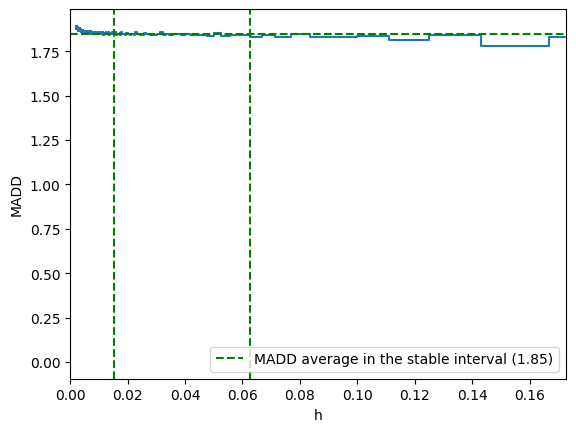

In [83]:
plot_stable_interval2(e, madd, indexes=result_stable3['indexes'], zoom='sup order', n0=n0, n1=n1)

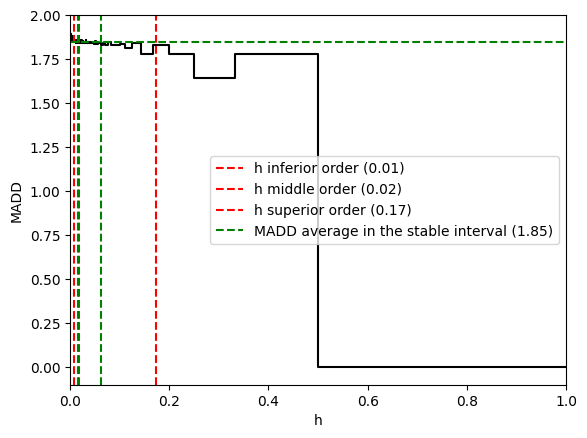

In [145]:
plot_stable_interval2(e, madd, indexes=result_stable3['indexes'], show_order=True, n0=n0, n1=n1)

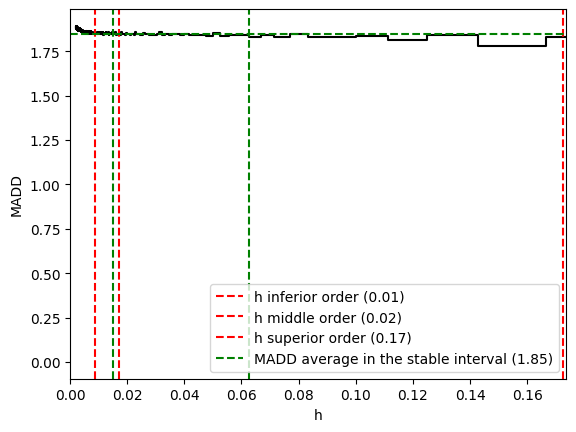

In [146]:
plot_stable_interval2(e, madd, show_stable=True, indexes=result_stable3['indexes'], zoom="sup order", n0=n0, n1=n1, show_order=True)

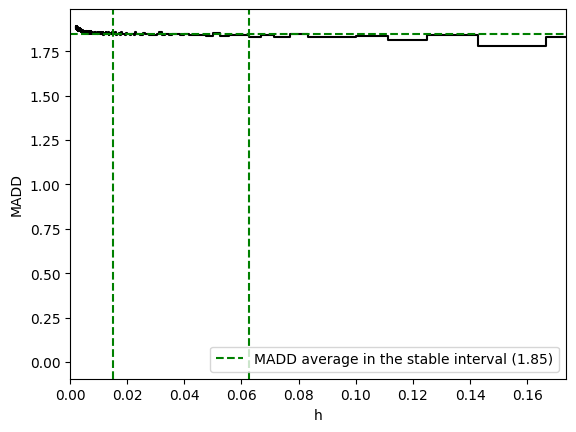

In [147]:
plot_stable_interval2(e, madd, show_stable=True, indexes=result_stable3['indexes'], zoom="sup order", n0=n0, n1=n1)